In [1]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
import numpy as np
import pandas as pd
import sklearn as sc
from sklearn.model_selection import train_test_split
import re, random
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import string
import copy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from gensim.models import word2vec
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
def analysis(labels,predictions):
  print("\nClassification Report: \n",classification_report(labels,predictions,target_names=['positive','negative'],zero_division=1))
  print("\nAccuracy: \n",accuracy_score(labels,predictions))
  conf_mat = confusion_matrix(labels,predictions)
  print("\nConfusion Matrix: \n",plot_confusion_matrix(conf_mat,colorbar=True,show_absolute=True,show_normed=True))

from sklearn import metrics
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

from scipy.special import comb
def rand_index_score(classes,clusters):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)



In [3]:
raw = pd.read_csv('./drive/MyDrive/ml/dataset.csv')
raw_comment = raw[['comment']].copy()
raw_sentiment = raw[['sentiment']].copy()

In [4]:
def advance_preproc(raw_commentt):
  cm_advance_preproc = copy.deepcopy(raw_commentt)
  #1
  cm_advance_preproc['comment'] = cm_advance_preproc['comment'].str.lower()
  #2
  cm_advance_preproc['comment'] = cm_advance_preproc['comment'].str.replace('\d+', '')
  #3
  cm_advance_preproc['comment'] = cm_advance_preproc['comment'].str.replace('[^\w\s]','')
  #4
  cm_advance_preproc['comment'] = cm_advance_preproc['comment'].str.strip()
  #5
  cm_advance_preproc['tokenized'] = cm_advance_preproc.apply(lambda row: word_tokenize(row['comment']), axis=1)
  #6
  stop = stopwords.words('english')
  cm_advance_preproc['tokenized'] = cm_advance_preproc['tokenized'].apply(lambda x: [item for item in x if item not in stop])
  #7
  stemmer= PorterStemmer()
  cm_advance_preproc['tokenized_stem'] = cm_advance_preproc['tokenized'].apply(lambda x: [stemmer.stem(y) for y in x])
  #8
  lemmatizer = nltk.stem.WordNetLemmatizer()
  cm_advance_preproc['tokenized'] = cm_advance_preproc['tokenized'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
  #return result
  return cm_advance_preproc

In [5]:
raw_sentiment.replace("positive",1,True)
raw_sentiment.replace("negative",0,True)

In [6]:
cm_advance_preproc = advance_preproc(raw_comment)

In [7]:
Y = np.ravel(raw_sentiment)

In [8]:
def make_word2vec(sentence):
    num_features = 250
    min_count = 10
    num_processor = 4
    context = 10
    downsampling = 0.001
    model = word2vec.Word2Vec(sentence, workers = num_processor, size = num_features, min_count = min_count,window = context, sample = downsampling)
    model.init_sims(replace = True)
    model_name = str(num_features)+"features_"+str(min_count)+"minwords"
    model.save(model_name)
    return model
def makeFeatureVec(review, model, num_features): 
    featureVec = np.zeros((num_features,), dtype = "float32")
    word_index = set(model.wv.index2word)
    nword = 0
    for word in review:
        if word in word_index:
            nword += 1
            featureVec = np.add(featureVec, model[word])
    featureVec = np.divide(featureVec, nword)        
    return featureVec

In [9]:
model = make_word2vec(cm_advance_preproc.tokenized)
output_w2v = []
for comment in cm_advance_preproc.tokenized:
    featureVec = makeFeatureVec(comment,model,250)
    output_w2v.append(featureVec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(output_w2v)
PCA_components = pd.DataFrame(principalComponents)

In [44]:
from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=2,init='k-means++',n_init=10).fit(PCA_components.iloc[:,:2])
kmeans_2 = KMeans(n_clusters=3,init='k-means++',n_init=10).fit(PCA_components.iloc[:,:2])
kmeans_3 = KMeans(n_clusters=5,init='k-means++',n_init=10).fit(PCA_components.iloc[:,:2])

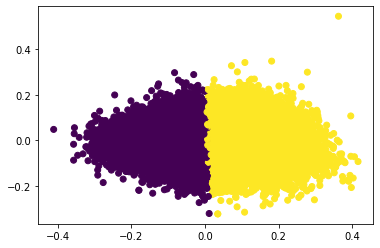

In [45]:
labels = kmeans_1.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()


Classification Report: 
               precision    recall  f1-score   support

    positive       0.62      0.66      0.64     22499
    negative       0.63      0.59      0.61     22501

    accuracy                           0.62     45000
   macro avg       0.62      0.62      0.62     45000
weighted avg       0.62      0.62      0.62     45000


Accuracy: 
 0.6237555555555555

Confusion Matrix: 
 (<Figure size 432x288 with 2 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f536e3e3690>)


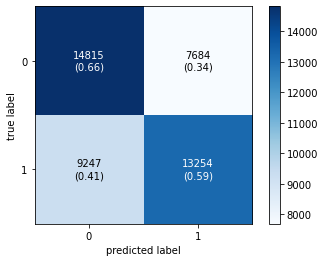

In [46]:
analysis(Y,labels)

In [47]:
rand_index_score(Y,labels)

0.5306204444049374

In [48]:
purity_score(Y,labels)

0.6237555555555555

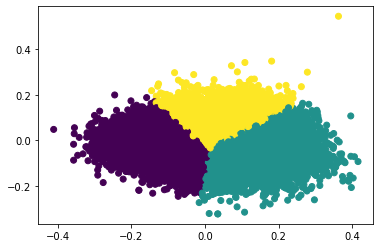

In [49]:
labels = kmeans_2.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

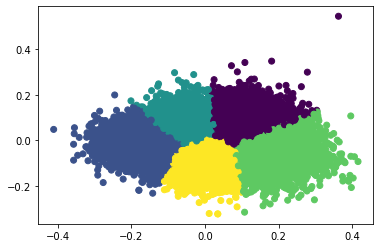

In [50]:
labels = kmeans_3.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

In [62]:
from sklearn.mixture import GaussianMixture
gmm_1 = GaussianMixture(n_components=2, random_state=1).fit(PCA_components.iloc[:,:2])
gmm_2 = GaussianMixture(n_components=3, random_state=0).fit(PCA_components.iloc[:,:2])
gmm_3 = GaussianMixture(n_components=5, random_state=0).fit(PCA_components.iloc[:,:2])

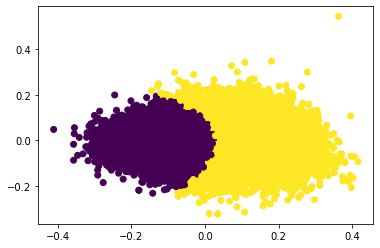

In [63]:
labels = gmm_1.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()


Classification Report: 
               precision    recall  f1-score   support

    positive       0.62      0.68      0.65     22499
    negative       0.64      0.58      0.61     22501

    accuracy                           0.63     45000
   macro avg       0.63      0.63      0.63     45000
weighted avg       0.63      0.63      0.63     45000


Accuracy: 
 0.6274666666666666

Confusion Matrix: 
 (<Figure size 432x288 with 2 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f536d9136d0>)


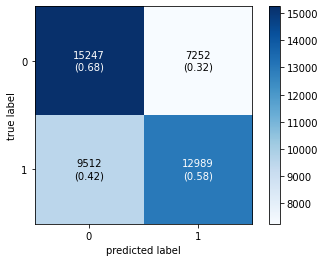

In [64]:
analysis(Y,labels)

In [65]:
rand_index_score(Y,labels)

0.5324851130025111

In [66]:
purity_score(Y,labels)

0.6274666666666666

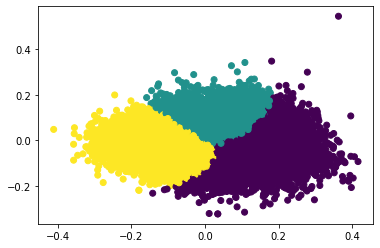

In [25]:
labels = gmm_2.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

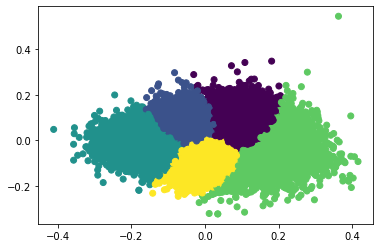

In [26]:
labels = gmm_3.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

In [119]:
from sklearn.cluster import Birch
birch_1 = Birch(n_clusters=2,threshold=0.079).fit(PCA_components.iloc[:,:2])

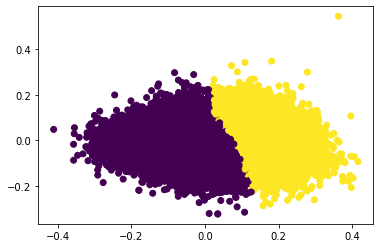

In [120]:
labels = birch_1.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()


Classification Report: 
               precision    recall  f1-score   support

    positive       0.59      0.86      0.70     22499
    negative       0.74      0.39      0.51     22501

    accuracy                           0.63     45000
   macro avg       0.66      0.63      0.60     45000
weighted avg       0.66      0.63      0.60     45000


Accuracy: 
 0.6261333333333333

Confusion Matrix: 
 (<Figure size 432x288 with 2 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f5372ba6610>)


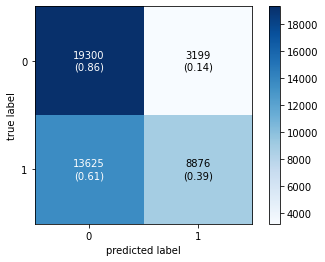

In [121]:
analysis(Y,labels)

In [122]:
rand_index_score(Y,labels)

0.5318088313073623

In [123]:
purity_score(Y,labels)

0.6261333333333333

In [32]:
birch_2 = Birch(n_clusters=3,threshold=0.1).fit(PCA_components.iloc[:,:2])

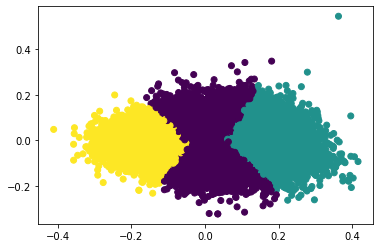

In [33]:
labels_specific = birch_2.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels_specific)
plt.show()

In [34]:
birch_3 = Birch(n_clusters=5,threshold=0.05).fit(PCA_components.iloc[:,:2])

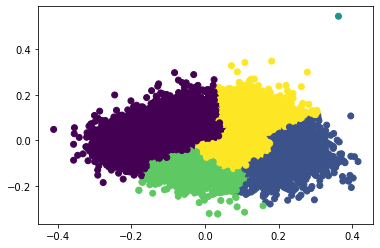

In [35]:
labels = birch_3.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

In [36]:
label0 = []
label1 = []
label2 = []
for index,item in enumerate(labels_specific):
  if item==0:
    label0.append(index)
  elif item==1:
    label1.append(index)
  else:
    label2.append(index)
label0_item = []
label1_item = []
label2_item = []
for index,item in enumerate(raw_comment.comment):
  if index in label0:
    label0_item.append(item)
  elif index in label1:
    label1_item.append(item)
  else:
    label2_item.append(item)

In [37]:
label0_item

["This must be one of the most overrated Spanish films in history. Its lack of subtlety and complexity and its total political correction make it really childish, with only good/bad characters. The world is just not like this, and good movies show complex characters with opposite impulses, dilemmas, etc. However, what I HATE most about this film is Bola's friend's father. The director tries to teach us a good lesson: tattoo artists with shaved heads are not always bad guys, in fact they can be better than the average looking dad (wow, this is like... philosophy, or something). Thank you, Achero. I'll propose you for the Nobel prize of literature.",
 'Some critics have compared Chop Shop with the theatrical releases of City of God and Pixote. I\'ve seen both of those as well as Chop Shop and like in many instances, I don\'t feel the comparison is warranted. City of God and Pixote surely had a much higher budget. Chop Shop is a low budget independent film about survival and hope, disappo

In [38]:
label1_item

['If you\'re a layman interested in quantum theory and string theory, read "The Elegant Universe" by Brian Greene of Columbia University, and "The Universe in a Nutshell" by Stephen Hawking of Cambridge.<br /><br />Recipe for #$*!:<br /><br />3 parts bombastic New Age pontificator, 2 parts pseudoscientist, 2 parts real scientist<br /><br />Mix together until ingredients are indistinguishable from each other and spread on celluloid thin enough that there is no discernible substance.<br /><br />Serving suggestion: barf bags.',
 "It's a simple fact that there are many of us from the 80's generation who grew up loving those loopy John Cusack comedies made by Savage Steve Holland, and while I prefer there other more bizarre, out-there flick, Better Off Dead, it's hard for me to dislike One Crazy Summer, a movie I grew up loving wholeheartedly as a kid into my teens. OCS was a follow-up to Better Off Dead, returning Cusack and Curtis Armstrong from that film. <br /><br />Cusack is Hoops, fol

In [39]:
label2_item

['Oh my god, it just doesn\'t get any worse than this!!! I always love silly little sci-fi B-movies that are so stupid they are funny and I thought that this would be one of those, but this was just so stupid I found it absolutely deplorable that it was allowed to be released. What were these people thinking? They are obviously not real filmmakers and I really hope that they have gone back to their day jobs after realizing that this is the best they could do! The acting and the not-so special effects were nowhere near the standard of even the lowest budget B-movies. And what is with the men dressed up as women, could they not find any women that wanted to appear in this crappy thing. No, probably not.<br /><br />I would give this a "0" if possible, it does not even deserve a "1" for awful. Do not waste your time (and especially not your money) on this horrible loser of a non-film!',
 "It's amazing that this no talent actor Chapa got all these well known stars to appear in this dismal, 

In [40]:
raw = pd.read_csv('./drive/MyDrive/ml/dataset2.csv')
raw_comment2 = raw[['comment']].copy()
raw_sentiment2 = raw[['sentiment']].copy()

In [41]:
cm_advance_preproc2 = advance_preproc(raw_comment2)

In [42]:
Y2 = np.ravel(raw_sentiment2)

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
def dummy(doc):
    return doc

cv = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy,
        max_features = 1000,
    )

X_new = cv.fit_transform(cm_advance_preproc2.tokenized)
X_new = X_new.todense()
X_train, X_val, Y_train, Y_val = train_test_split(X_new, Y2, test_size=0.2, random_state=1)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Classification Report: 
               precision    recall  f1-score   support

    positive       0.81      0.59      0.68        51
    negative       0.67      0.86      0.75        49

    accuracy                           0.72       100
   macro avg       0.74      0.72      0.72       100
weighted avg       0.74      0.72      0.72       100


Accuracy: 
 0.72

Confusion Matrix: 
 (<Figure size 432x288 with 2 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f5372d2da50>)


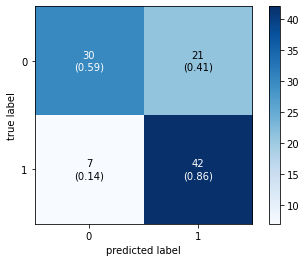

In [125]:
clf = MLPClassifier(random_state=1, max_iter=300,hidden_layer_sizes=(500,250,100,50,10,5,),activation='tanh').fit(X_train, Y_train)
predict_label = clf.predict(X_val)
analysis(Y_val,predict_label)

In [180]:
model = word2vec.Word2Vec.load('./250features_40minwords')

In [181]:
output_w2v_2 = []
for comment in cm_advance_preproc2.tokenized:
    featureVec = makeFeatureVec(comment,model,250)
    output_w2v_2.append(featureVec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [137]:
output_w2v_2=np.nan_to_num(output_w2v_2, copy=True, nan=0.0, posinf=0.0, neginf=0.0)

In [182]:
import pickle
filename = 'best.pkl'
best_model = pickle.load(open(filename,'rb'))

In [183]:
X_train, X_val, Y_train, Y_val = train_test_split(output_w2v_2, Y2, test_size=0.2,random_state=1)
best_model.fit(X_train,Y_train,sample_weight=None)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=True)


Classification Report: 
               precision    recall  f1-score   support

    positive       0.75      0.76      0.76        51
    negative       0.75      0.73      0.74        49

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100


Accuracy: 
 0.75

Confusion Matrix: 
 (<Figure size 432x288 with 2 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f537271a3d0>)


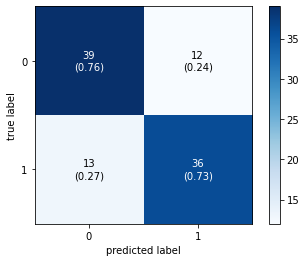

In [184]:
labels = best_model.predict(X_val)
analysis(Y_val,labels)